In [3]:
!python --version


Python 3.12.4


In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [1]:
import os
import os

# Construct the path to the Downloads folder
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads")

# Change the current working directory to the Downloads folder
os.chdir(downloads_path)

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")
HOME = os.getcwd()
print(HOME)

Current working directory: C:\Users\vypal\Downloads
C:\Users\vypal\Downloads


In [3]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196  Python-3.12.4 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Setup complete  (16 CPUs, 15.2 GB RAM, 210.4/226.9 GB disk)


In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

C:\Users\vypal\Downloads\yolodataset


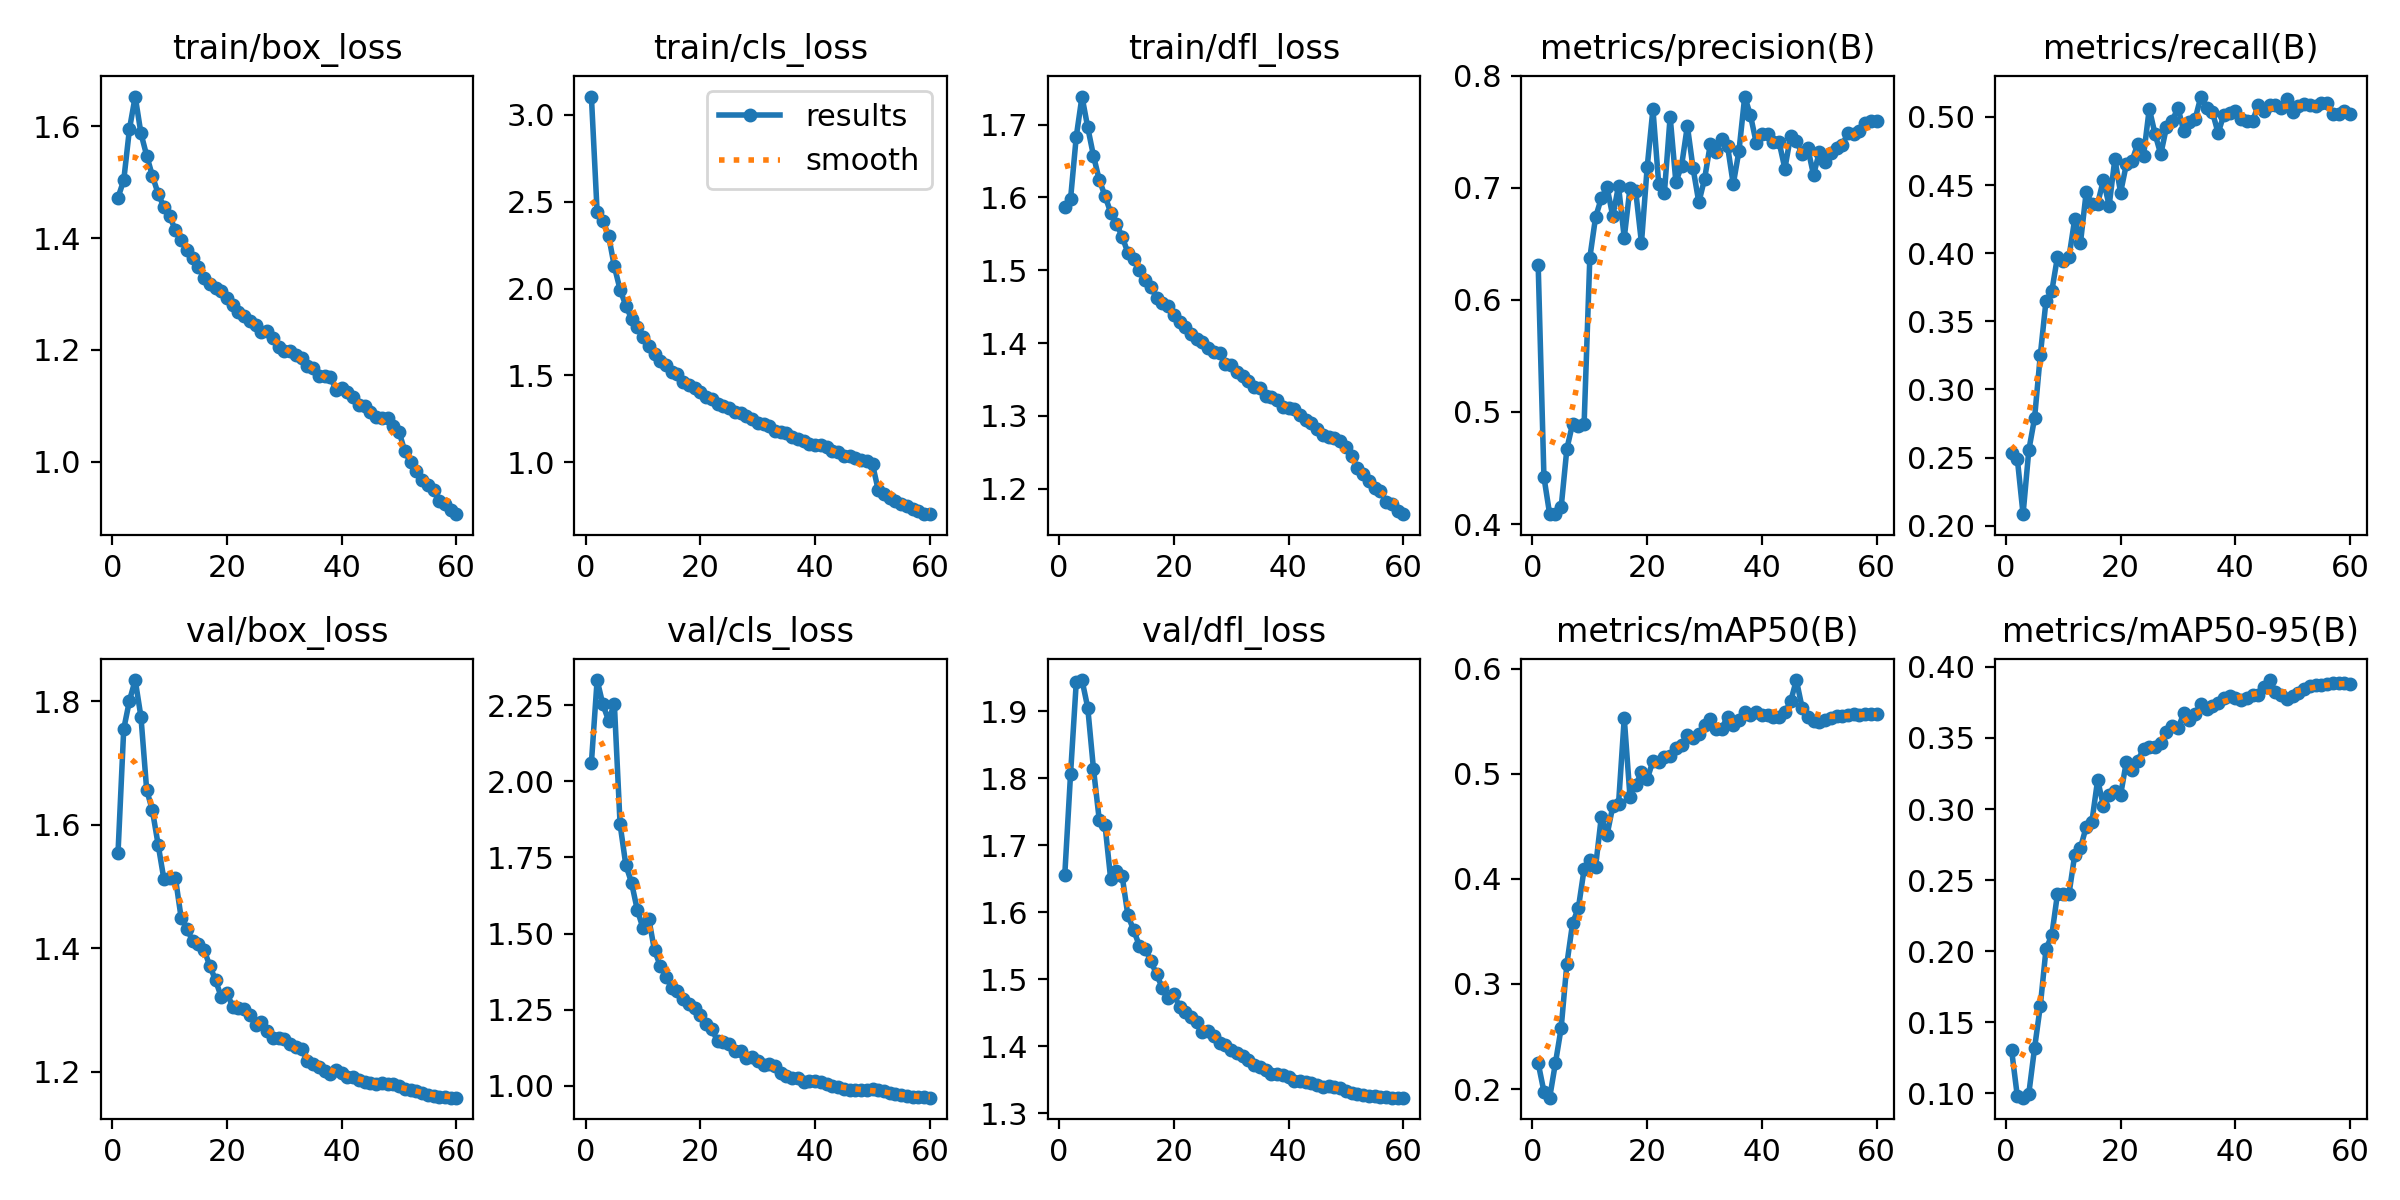

In [5]:
%cd {HOME}/yolodataset
Image(filename=f'runs/detect/train/results.png', width=600)

In [7]:
!ls


0.4.33
README.dataset.txt
README.roboflow.txt
data.yaml
runs
test
train
valid
yolov8n.pt


In [21]:
!pip install mediapipe


   ---------------------------------------- 0.0/50.8 MB ? eta -:--:--
   ---------------------------------------- 0.4/50.8 MB 7.4 MB/s eta 0:00:07
    --------------------------------------- 0.8/50.8 MB 8.2 MB/s eta 0:00:07
    --------------------------------------- 1.2/50.8 MB 8.7 MB/s eta 0:00:06
   - -------------------------------------- 1.6/50.8 MB 9.0 MB/s eta 0:00:06
   - -------------------------------------- 2.1/50.8 MB 9.0 MB/s eta 0:00:06
   - -------------------------------------- 2.5/50.8 MB 8.9 MB/s eta 0:00:06
   -- ------------------------------------- 2.9/50.8 MB 9.3 MB/s eta 0:00:06
   -- ------------------------------------- 3.2/50.8 MB 8.8 MB/s eta 0:00:06
   -- ------------------------------------- 3.6/50.8 MB 8.5 MB/s eta 0:00:06
   -- ------------------------------------- 3.6/50.8 MB 8.5 MB/s eta 0:00:06
   --- ------------------------------------ 4.1/50.8 MB 8.8 MB/s eta 0:00:06
   --- ------------------------------------ 4.4/50.8 MB 7.8 MB/s eta 0:00:06
   ---

In [1]:
!pip install pyttsx3

   ---------------------------------------- 0.0/219.4 kB ? eta -:--:--
   ---------------------------------------- 219.4/219.4 kB 4.5 MB/s eta 0:00:00


In [ ]:
import cv2
import math
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors
import pyttsx3
import threading
from queue import Queue

# Load the YOLOv8 model with classification capabilities
model = YOLO("best.pt")

# Initialize the text-to-speech engine
engine = pyttsx3.init()

# Specify the IP address and port of the camera stream
camera_url = 0
cap = cv2.VideoCapture(camera_url)

# Check if the camera stream is opened successfully
if not cap.isOpened():
    print("Error: Unable to open the camera stream.")
    exit()

# Set the video writer parameters if you want to save the output
w, h, fps = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FPS)))
out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'MJPG'), fps, (w, h))

center_point = (w // 2, h)  # Center point of the frame
known_width = 0.5  # Known width of the object in meters (you need to set this)
focal_length = 1000  # Focal length in pixels (you need to calibrate this)

txt_color, txt_background, bbox_clr = ((0, 0, 0), (255, 255, 255), (255, 0, 255))

text_font_scale = 0.5  # Adjust this value to change the text size
text_thickness = 2  # Adjust this value to change the text thickness

feedback_queue = Queue()

def give_voice_feedback():
    while True:
        message = feedback_queue.get()
        if message is None:
            break
        engine.say(message)
        engine.runAndWait()

tts_thread = threading.Thread(target=give_voice_feedback)
tts_thread.start()

try:
    while True:
        # Read the frame from the camera stream
        ret, im0 = cap.read()

        if not ret:
            print("Error capturing frame from the camera stream.")
            break

        annotator = Annotator(im0, line_width=2)
        results = model(im0)

        for result in results:
            boxes = result.boxes.xyxy.cpu()

            for i, box in enumerate(boxes):
                cls = int(result.boxes.cls[i])
                label = model.names[cls]
                annotator.box_label(box, label, color=colors(cls, True))
            
                x1, y1 = int((box[0] + box[2]) // 2), int((box[1] + box[3]) // 2)  # Bounding box centroid
                box_width = box[2] - box[0]
                distance = (known_width * focal_length) / box_width

                text = f"{distance:.2f} m"
                text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, text_font_scale, text_thickness)

                # Adjust the text position based on the bounding box location
                text_x = max(10, x1 - text_size[0] // 2)
                text_x = min(text_x, im0.shape[1] - text_size[0] - 10)
                text_y = max(y1 - text_size[1] - 10, 10)

                cv2.rectangle(im0, (text_x - 5, text_y - 5), (text_x + text_size[0] + 5, text_y + text_size[1] + 5), txt_background, -1)
                cv2.putText(im0, text, (text_x, text_y + text_size[1]), cv2.FONT_HERSHEY_SIMPLEX, text_font_scale, txt_color, text_thickness)

                # Check for pothole detection and provide voice guidance
                if label == "pothole":
                    if x1 < w // 3:  # Pothole on the left
                        feedback_message = f"Pothole on the left, move right or walk straight. Distance: {distance:.2f} meters."
                    elif x1 > 2 * (w // 3):  # Pothole on the right
                        feedback_message = f"Pothole on the right, move left or walk straight. Distance: {distance:.2f} meters."
                    else:  # Pothole in the center
                        feedback_message = f"Pothole straight ahead, move left or right. Distance: {distance:.2f} meters."
                    
                    print(feedback_message)
                    feedback_queue.put(feedback_message)

        # Write the frame to the video writer (if enabled)
        out.write(im0)

        # Display the frame
        cv2.imshow("visioneye-distance-calculation", im0)

        # Press 'q' to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    # Stop the TTS thread
    feedback_queue.put(None)
    tts_thread.join()

    # Release resources
    out.release()
    cap.release()
    cv2.destroyAllWindows()



0: 480x640 1 Person detection - v16 2023-05-27 6-46pm, 2 cars, 125.5ms
Speed: 5.0ms preprocess, 125.5ms inference, 163.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Person detection - v16 2023-05-27 6-46pm, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Person detection - v16 2023-05-27 6-46pm, 12.0ms
Speed: 1.0ms preprocess, 12.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Person detection - v16 2023-05-27 6-46pm, 12.3ms
Speed: 1.0ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Person detection - v16 2023-05-27 6-46pm, 13.1ms
Speed: 0.0ms preprocess, 13.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Person detection - v16 2023-05-27 6-46pm, 14.7ms
Speed: 0.0ms preprocess, 14.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Person detecti

0.18.1


In [ ]:
import cv2
import math
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors
import pyttsx3
import threading
from queue import Queue

# Load the YOLOv8 model with classification capabilities
model = YOLO("best.pt")

# Initialize the text-to-speech engine
engine = pyttsx3.init()

# Specify the IP address and port of the camera stream
camera_url = 0
cap = cv2.VideoCapture(camera_url)

# Check if the camera stream is opened successfully
if not cap.isOpened():
    print("Error: Unable to open the camera stream.")
    exit()

# Set the video writer parameters if you want to save the output
w, h, fps = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FPS)))
out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'MJPG'), fps, (w, h))

center_point = (w // 2, h)  # Center point of the frame
known_width = 0.5  # Known width of the object in meters (you need to set this)
focal_length = 1000  # Focal length in pixels (you need to calibrate this)

txt_color, txt_background, bbox_clr = ((0, 0, 0), (255, 255, 255), (255, 0, 255))

text_font_scale = 0.5  # Adjust this value to change the text size
text_thickness = 2  # Adjust this value to change the text thickness

feedback_queue = Queue()
frame_queue = Queue(maxsize=10)

def capture_frames():
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if not frame_queue.full():
            frame_queue.put(frame)

def process_frames():
    while True:
        if not frame_queue.empty():
            frame = frame_queue.get()
            annotator = Annotator(frame, line_width=2)
            results = model(frame)

            for result in results:
                boxes = result.boxes.xyxy.cpu()

                for i, box in enumerate(boxes):
                    cls = int(result.boxes.cls[i])
                    label = model.names[cls]
                    annotator.box_label(box, label, color=colors(cls, True))
                
                    x1, y1 = int((box[0] + box[2]) // 2), int((box[1] + box[3]) // 2)  # Bounding box centroid
                    box_width = box[2] - box[0]
                    distance = (known_width * focal_length) / box_width

                    text = f"{distance:.2f} m"
                    text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, text_font_scale, text_thickness)

                    # Adjust the text position based on the bounding box location
                    text_x = max(10, x1 - text_size[0] // 2)
                    text_x = min(text_x, frame.shape[1] - text_size[0] - 10)
                    text_y = max(y1 - text_size[1] - 10, 10)

                    cv2.rectangle(frame, (text_x - 5, text_y - 5), (text_x + text_size[0] + 5, text_y + text_size[1] + 5), txt_background, -1)
                    cv2.putText(frame, text, (text_x, text_y + text_size[1]), cv2.FONT_HERSHEY_SIMPLEX, text_font_scale, txt_color, text_thickness)

                    # Check for pothole detection and provide voice guidance
                    if label == "stairs":
                        if x1 < w // 3:  # Pothole on the left
                            feedback_message = f"Pothole on the left, move right or walk straight. Distance: {distance:.2f} meters."
                        elif x1 > 2 * (w // 3):  # Pothole on the right
                            feedback_message = f"Pothole on the right, move left or walk straight. Distance: {distance:.2f} meters."
                        else:  # Pothole in the center
                            feedback_message = f"Pothole straight ahead, move left or right. Distance: {distance:.2f} meters."
                        
                        print(feedback_message)
                        feedback_queue.put(feedback_message)

            # Write the frame to the video writer (if enabled)
            out.write(frame)

            # Display the frame
            cv2.imshow("visioneye-distance-calculation", frame)

            # Press 'q' to exit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

def give_voice_feedback():
    while True:
        message = feedback_queue.get()
        if message is None:
            break
        engine.say(message)
        engine.runAndWait()

# Start threads for capturing and processing frames
capture_thread = threading.Thread(target=capture_frames)
process_thread = threading.Thread(target=process_frames)
tts_thread = threading.Thread(target=give_voice_feedback)

capture_thread.start()
process_thread.start()
tts_thread.start()

try:
    capture_thread.join()
    process_thread.join()
finally:
    # Stop the TTS thread
    feedback_queue.put(None)
    tts_thread.join()

    # Release resources
    out.release()
    cap.release()
    cv2.destroyAllWindows()



0: 480x640 1 Person detection - v16 2023-05-27 6-46pm, 111.8ms
Speed: 3.0ms preprocess, 111.8ms inference, 100.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Person detection - v16 2023-05-27 6-46pm, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 9.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Person detection - v16 2023-05-27 6-46pm, 11.8ms
Speed: 0.0ms preprocess, 11.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Person detection - v16 2023-05-27 6-46pm, 13.2ms
Speed: 0.0ms preprocess, 13.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Person detection - v16 2023-05-27 6-46pm, 9.0ms
Speed: 1.1ms preprocess, 9.0ms inference, 9.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Person detection - v16 2023-05-27 6-46pm, 17.9ms
Speed: 0.0ms preprocess, 17.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Person detection - v16 202


0: 480x640 2 Person detection - v16 2023-05-27 6-46pms, 130.0ms
Speed: 10.0ms preprocess, 130.0ms inference, 90.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 Person detection - v16 2023-05-27 6-46pms, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 Person detection - v16 2023-05-27 6-46pms, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 Person detection - v16 2023-05-27 6-46pms, 14.2ms
Speed: 0.0ms preprocess, 14.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 Person detection - v16 2023-05-27 6-46pms, 8.3ms
Speed: 1.0ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 Person detection - v16 2023-05-27 6-46pms, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Person detection - v16 2